In [32]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Concatenate, TimeDistributed, LSTM, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.autograph.experimental import do_not_convert
from sklearn.model_selection import train_test_split
import numpy as np
from helper_funcs import gen_samples
from scipy.fft import rfftfreq
import pickle
import matplotlib.pyplot as plt
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Load and split dataset

# File paths
transfer_directory_path = os.path.join("Data", "synth_transfer_df.parquet")
general_directory_path = os.path.join("Data", "synth_general_df.parquet")

# Load the dataframes
synth_transfer_df = pd.read_parquet(transfer_directory_path)
synth_general_df = pd.read_parquet(general_directory_path)

# Ensure column names match
assert list(synth_transfer_df.columns) == list(synth_general_df.columns), "Column names do not match!"

# Add a dataset identifier for stratification
synth_transfer_df['dataset'] = 'transfer'
synth_general_df['dataset'] = 'general'

# Combine the datasets
df = pd.concat([synth_transfer_df, synth_general_df], axis=0)
df.reset_index(drop=True, inplace=True)

# Random state for reproducibility
rs = 1

print(len(df))

# Split each dataset (transfer and general) independently
transfer_train, transfer_temp = train_test_split(
    synth_transfer_df,
    test_size=0.3,  # 30% of transfer dataset
    stratify=synth_transfer_df['species'],  # Stratify based on species
    random_state=rs
)

general_train, general_temp = train_test_split(
    synth_general_df,
    test_size=0.3,  # 30% of general dataset
    stratify=synth_general_df['species'],  # Stratify based on species
    random_state=rs
)

# Combine the training datasets from transfer and general
train_df = pd.concat([transfer_train, general_train], axis=0).reset_index(drop=True)

# Split temp datasets (transfer and general) into test and validation
transfer_test, transfer_val = train_test_split(
    transfer_temp,
    test_size=0.5,  # Split evenly into test and validation
    stratify=transfer_temp['species'],
    random_state=rs + 1
)

general_test, general_val = train_test_split(
    general_temp,
    test_size=0.5,  # Split evenly into test and validation
    stratify=general_temp['species'],
    random_state=rs + 1
)

# Combine test and validation datasets from transfer and general
test_df = pd.concat([transfer_test, general_test], axis=0).reset_index(drop=True)
val_df = pd.concat([transfer_val, general_val], axis=0).reset_index(drop=True)

# # Verify distribution of species and datasets
# print("Training dataset:")
# print(train_df['species'].value_counts())
# print(train_df['dataset'].value_counts())

# print("\nValidation dataset:")
# print(val_df['species'].value_counts())
# print(val_df['dataset'].value_counts())

# print("\nTest dataset:")
# print(test_df['species'].value_counts())
# print(test_df['dataset'].value_counts())


7637


In [34]:
# Prepare samples
print("Generating Training Samples")
X_train, y_train, mins_maxes_train, isolated_peaks_train = gen_samples(train_df)
print("Generating Test Samples")
X_test, y_test, mins_maxes_test, isolated_peaks_test = gen_samples(test_df)
print("Generating Validation Samples")
X_val, y_val, mins_maxes_val, isolated_peaks_val = gen_samples(val_df)

Generating Training Samples
Generating Test Samples
Generating Validation Samples


In [35]:
# Crop num samples for testing
M = 1000
X_train = X_train[:M, :]
X_val = X_val[:M, :]
X_test = X_test[:M, :]

y_train = y_train[:M, :, :]
y_val = y_val[:M, :, :]
y_test = y_test[:M, :, :]

isolated_peaks_val = isolated_peaks_val[:M, :]

In [36]:
# Expand axes for conv layers
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [37]:
k=3
peak_encourage=1
include_LSTM=False
epochs = 1
lr = 0.001
model_version = f"V1_k-{k}_PE-{peak_encourage}_LSTM-{include_LSTM}_Epochs-{epochs}_LR-{lr}"
batch_size = 32
patience = 15
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]

In [41]:
# Define custom loss and metric callbacks
def custom_loss(y_true, y_pred):
    """
    Custom loss function using predictions and weights.
    """
    # Compute binary cross-entropy loss
    bce_loss = tf.keras.backend.binary_crossentropy(y_true[:, :, 0], y_pred[:, :, 0])  # Shape (batch_size, N)

    # prom = y_true[:, :, 2] is the 3rd node label, shape (batch_size, N)
    # If prom < 0, weight is 1 (weight of BCE loss for non-peak bins), else apply weight_func
    weights = tf.where(y_true[:, :, 2] < 0, tf.ones_like(y_true[:, :, 2]), peak_encourage/(1+tf.exp(k-y_true[:, :, 2])))  
    # Apply weights
    weighted_bce_loss = bce_loss * weights  # Shape (batch_size, bins_per_sample)

    # Average loss across all samples and bins
    total_loss = tf.reduce_mean(weighted_bce_loss)  # Scalar

    return total_loss



def peak_counting_error(isolated_peaks_val, val_predictions, threshold_list=threshold_list):
    # Just grab the labels since we're ignoring width and height
    val_predictions = val_predictions[:, :, 0]
    M = isolated_peaks_val.shape[0] # Number of samples
    assert M == val_predictions.shape[0], "Mismatch in number of samples!"
    best_error = 10000  # Initial large value for minimizing error
    best_thresh = None
    for thresh in threshold_list:
        current_error = 0
        val_predictions_snapped = (val_predictions > thresh).astype(int)
        
        for row in range(M):
            predictions_row = val_predictions_snapped[row, :]
            isolated_labels_row = isolated_peaks_val[row, :]
            
            # We want to go along the predictions row, and find continuous chunks of 1s and 0s.
            # Every time a chunk ends, we then check how many peaks were truly in that chunk (by counting the 1s in those indices in isolated_labels_row)
            # We then add the square of the differences between the predicted number of peaks and the actual number of peaks to total_error
            # The predicted number of peaks in a chunk of 1s is always 1, and the predicted number of peaks in a chunk of 0s is always 0.
            
            # Track the current chunk
            current_chunk_value = predictions_row[0]
            current_chunk_start = 0

            for idx in range(1, len(predictions_row) + 1):  # +1 to handle the last chunk
                if idx == len(predictions_row) or predictions_row[idx] != current_chunk_value:
                    # Chunk ends here
                    chunk_end = idx
                    chunk_labels = isolated_labels_row[current_chunk_start:chunk_end]
                    
                    # Predicted peaks for this chunk
                    predicted_peaks = current_chunk_value
                    # Actual peaks for this chunk
                    actual_peaks = int(chunk_labels.sum())  # Count the 1s in the chunk
                    
                    # Add squared error to total_error
                    current_error += (predicted_peaks - actual_peaks) ** 2
                    
                    # Start a new chunk
                    current_chunk_value = predictions_row[idx] if idx < len(predictions_row) else None
                    current_chunk_start = idx
        
        current_error = current_error / M
        print(f"Peak counting error for threshold {thresh}: {current_error}")
        # Update the best threshold if this one performs better
        if current_error < best_error:
            best_error = current_error
            best_thresh = thresh
    
    print(f"Best threshold: {best_thresh}, Best Peak Counting Error: {best_error}")
    return best_error, best_thresh
        

class ValidationMetricCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, metric_name="peak_counting_error"):
        super(ValidationMetricCallback, self).__init__()
        self.validation_data = validation_data
        self.metric_name = metric_name
    
    @do_not_convert
    def on_epoch_end(self, epoch, logs=None):
        val_x, (val_y, isolated_peaks_val) = self.validation_data  # Unpack extra labels
        val_predictions = self.model.predict(val_x, verbose=0)
        val_predictions = val_predictions[:, :, 0]
        M = tf.shape(isolated_peaks_val)[0]  # Number of samples
        tf.assert_equal(M, tf.shape(val_predictions)[0], message="Mismatch in number of samples!")
        
        thresholds = tf.constant(threshold_list, dtype=tf.float32)
        best_error = tf.constant(1e10, dtype=tf.float32)  # Initial large value for minimizing error
        best_thresh = tf.constant(0.0, dtype=tf.float32)

        
        def calculate_error(thresh):
            val_predictions_snapped = tf.cast(val_predictions > thresh, tf.int32)

            def process_row(row_idx):
                predictions_row = val_predictions_snapped[row_idx]
                isolated_labels_row = isolated_peaks_val[row_idx]

                chunk_boundaries = tf.concat([[0], tf.where(tf.not_equal(predictions_row[:-1], predictions_row[1:]))[:, 0] + 1, [tf.size(predictions_row)]], axis=0)
                chunk_start_indices = chunk_boundaries[:-1]
                chunk_end_indices = chunk_boundaries[1:]

                def process_chunk(start, end):
                    chunk_labels = isolated_labels_row[start:end]
                    predicted_peaks = tf.cast(predictions_row[start], tf.float32)  # Cast to float32
                    actual_peaks = tf.cast(tf.reduce_sum(chunk_labels), tf.float32)  # Cast to float32
                    return tf.square(predicted_peaks - actual_peaks)

                squared_errors = tf.map_fn(
                    lambda indices: process_chunk(indices[0], indices[1]),
                    (chunk_start_indices, chunk_end_indices),
                    fn_output_signature=tf.float32
                )
                return tf.reduce_sum(squared_errors)

            total_error = tf.map_fn(process_row, tf.range(M), fn_output_signature=tf.float32)
            return tf.reduce_mean(total_error)

        def update_best(thresh, current_error, best_error, best_thresh):
            better = current_error < best_error
            return tf.cond(
                better,
                lambda: (current_error, thresh),
                lambda: (best_error, best_thresh)
            )

        for thresh in thresholds:
            current_error = calculate_error(thresh)
            best_error, best_thresh = update_best(thresh, current_error, best_error, best_thresh)

        # Round the best_thresh to 3 decimal places
        rounded_best_thresh = tf.round(best_thresh * 1000) / 1000.0  # Rounds to 3 decimal places
    
        # Add space before printing the custom output
        tf.print("\n--------------------------------------------")
        tf.print(f"Best threshold: {rounded_best_thresh}, Best Peak Counting Error: {best_error}")
        tf.print("--------------------------------------------\n")

        logs[self.metric_name] = best_error


class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []  # List to store time per epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()  # Record start time of epoch

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time  # Calculate epoch duration
        self.epoch_times.append(epoch_time)  # Save to list

In [42]:
# Define the input length / number of frequency bins (N)
N = 8192

# Input layer
input_layer = Input(shape=(N, 1), name="Input")
# Inception-like layer with 1D convolutions
convs = []
# We'll base our kernel choices on the hwhm distribution of the peaks. 
# Thin peaks are in 3Hz-10Hz range --> 5-15 bins
# Wide peaks are in 10Hz-100Hz range --> 15-149 bins
# We choose filters at a range of scales, odd (to facilitate being cenetered around a peak)
# and we want more filters for the medium-small range since there are more peaks at this scale.
# Otherwise largely arbitrarily.
kernels = [(3, 4), (5, 8), (9, 16), (15, 32), (31, 32), (55, 32), (71, 16), (101, 8), (149, 4), (201, 2)]
for kernel_size, num_filters in kernels:
    convs.append(Conv1D(num_filters, kernel_size=kernel_size, activation='relu', padding='same', name=f"Conv_{kernel_size}")(input_layer))

# Concatenate the outputs of all convolutional layers
concat_layer = Concatenate(name="Inception_Concat")(convs)

# Time Distributed Dense Layers
td_dense64 = TimeDistributed(Dense(64, activation='relu'), name="Dense_64")(concat_layer)
td_dense32A = TimeDistributed(Dense(32, activation='relu'), name="Dense_32A")(td_dense64)
if include_LSTM:
    bd_LSTM = Bidirectional(LSTM(16, return_sequences=True), name="LSTM")(td_dense32A)
    td_dense32B = TimeDistributed(Dense(32, activation='relu'), name="Dense_32B")(bd_LSTM)
else:
    td_dense32B = TimeDistributed(Dense(32, activation='relu'), name="Dense_32B")(td_dense32A)
td_dense16 = TimeDistributed(Dense(16, activation='relu'), name="Dense_16")(td_dense32B)

# Final layer with 3 outputs per input bin
output_layer = TimeDistributed(Dense(3, activation='sigmoid'), name="Output")(td_dense16)

# Define the model to output both predictions and weights
model = tf.keras.Model(
    inputs=input_layer, 
    outputs=output_layer,  # Explicitly define both outputs
    name=model_version
)


# Compile the model (lambda function in loss to allow for prominences to be passed in as weights)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    # loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, weights)
    loss=custom_loss
)

model.summary()


Model: "V1_k-3_PE-1_LSTM-False_Epochs-1_LR-0.001"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 8192, 1)]    0           []                               
                                                                                                  
 Conv_3 (Conv1D)                (None, 8192, 4)      16          ['Input[0][0]']                  
                                                                                                  
 Conv_5 (Conv1D)                (None, 8192, 8)      48          ['Input[0][0]']                  
                                                                                                  
 Conv_9 (Conv1D)                (None, 8192, 16)     160         ['Input[0][0]']                  
                                                           

In [43]:
start_time = time.time()
model_path = os.path.join("PP Models", f"{model_version}.keras")
epoch_model_path = os.path.join("PP Models (All Epochs)", f"{model_version} - ", "epoch{epoch:02d}.keras")

time_callback = TimeHistory()

# Add callbacks for better training
callbacks = [
    # ValidationMetricCallback(validation_data=(X_val, (y_val, isolated_peaks_val)), metric_name="peak_counting_error"),
    # EarlyStopping(monitor="peak_counting_error", patience=patience, restore_best_weights=True, verbose=1),  # Stop if no improvement for {patience} epochs
    ModelCheckpoint(model_path, save_best_only=True, monitor="val_loss"),  # Save the best model
    ModelCheckpoint(epoch_model_path, save_best_only=False, monitor="peak_counting_error"),  # Save all models model
    time_callback
]

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

# Validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)


# Train the model
history = model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=epochs,        # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=callbacks,    # Add callbacks for early stopping and checkpointing
    verbose=1               # Verbose output
)

history.history['epoch_times'] = time_callback.epoch_times

with open(os.path.join("PP Model Histories", f"{model_version}_history.pkl"), 'wb') as file:
    pickle.dump(history.history, file)
    
elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

32/32 [==============================] - ETA: 0s - loss: 0.3318
--------------------------------------------
Best threshold: 0.30000001192092896, Best Peak Counting Error: 389.51800537109375
--------------------------------------------

32/32 [==============================] - 65s 2s/step - loss: 0.3318 - val_loss: 0.0256 - peak_counting_error: 389.5180
Execution time: 64.89 seconds


In [83]:
model = load_model(os.path.join("PP Model", f"{model_version}.keras"), custom_objects={"custom_loss": custom_loss})

In [84]:
# Assuming the predicted values are probabilities from 0 to 1
val_pred = model.predict(X_val)  # Predicted probabilities or binary values

36/36 [==============================] - 5s 134ms/step


[1.0879586e-26 7.4104473e-24 4.4572247e-22 ... 2.8813995e-06 5.5534161e-07
 1.5973072e-07]
[0.88858134 0.89260557 0.89047769 ... 0.13012451 0.10177725 0.10663693]


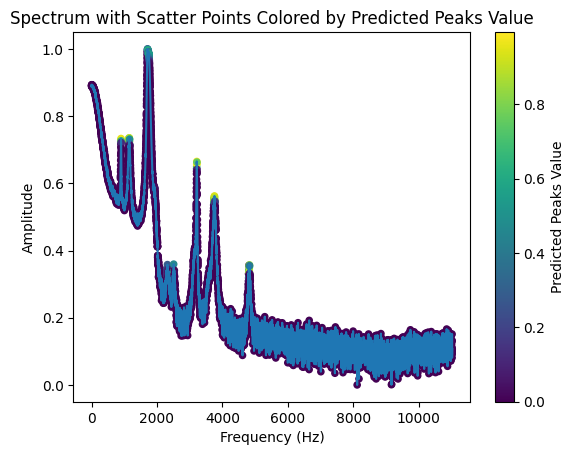

In [19]:
# CHECKING PREDICTIONS

sample_idx = 55
# Get spectrum (last 0 is just becuase this has shape (n_Samples, bins, 1))
spectrum = X_val[sample_idx, :, 0]
# Get predictions (last 0 is because we want 
predicted_peaks = val_pred[sample_idx, :, 0] 
print(predicted_peaks)
print(X_val[sample_idx, :, 0])


# Frequency axis for the spectrum
f = rfftfreq(32768, 1/44100)[0:8192]

# Plot the spectrum
plt.plot(f, spectrum, label='Original Spectrum')

# Add colors depending on percentage of prediction
scatter = plt.scatter(f, spectrum, c=predicted_peaks, cmap='viridis', s=20)

# Add color bar
plt.colorbar(scatter, label='Predicted Peaks Value')

# Add labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectrum with Scatter Points Colored by Predicted Peaks Value')
plt.show()

In [12]:
# Calculate Peak Counting Error for all hyperparameter combos
epochs=25
threshold_list = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for include_LSTM in [False, True]:
    for k in [0, 3]:
        for peak_encourage in [1, 5, 10, 15]:
            k=3
            lr = 0.001
            model_version = f"V1_k-{k}_PE-{peak_encourage}_LSTM-{include_LSTM}_Epochs-{epochs}_LR-{lr}"
            batch_size = 32
            patience = 15
            
            model = load_model(os.path.join("PP Models LESS THRESH", f"{model_version}.keras"), custom_objects={"custom_loss": custom_loss})
            # Assuming the predicted values are probabilities from 0 to 1
            test_pred = model.predict(X_test)  # Predicted probabilities or binary values
            best_error, best_thresh = peak_counting_error(isolated_peaks_test, test_pred, threshold_list=threshold_list)

36/36 [==============================] - 22s 599ms/step
Peak counting error for threshold 0.01: 19.112565445026178
Peak counting error for threshold 0.03: 9.739965095986038
Peak counting error for threshold 0.05: 7.719022687609075
Peak counting error for threshold 0.1: 5.37958115183246
Peak counting error for threshold 0.2: 4.883944153577661
Peak counting error for threshold 0.3: 5.12041884816754
Peak counting error for threshold 0.4: 5.610820244328098
Peak counting error for threshold 0.5: 6.450261780104712
Peak counting error for threshold 0.6: 7.719022687609075
Peak counting error for threshold 0.7: 9.679755671902269
Peak counting error for threshold 0.8: 13.230366492146597
Peak counting error for threshold 0.9: 24.728621291448516
Best threshold: 0.2, Best Peak Counting Error: 4.883944153577661


In [ ]:
""""""""""""""""""""""""""""""""""""""""""""""""

In [ ]:
# CHECKING PEAK LABELS FOR ERRORS

sample_idx = 0
spectrum = X_train[sample_idx, :]
peak_labels = y_train[sample_idx, :, 0]

# Frequency axis for the spectrum
f = rfftfreq(32768, 1/44100)[0:8192]

# Find indices where there are peaks (1 in predicted_peaks)
peak_indices = np.where(peak_labels==1)[0]

# Plot the spectrum
plt.plot(f, spectrum, label='Original Spectrum')

# Plot the peaks as scatter points
plt.scatter(f[peak_indices], spectrum[peak_indices], color='red', label='Labeled Peaks')

# Add labels and legend
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Verify Custom Loss
# Example data: batch_size=4, N=5, nodes=3
y_true = np.array([
    [[0, 0.5, 0.7], [0, 0.2, -1], [0, 10000, -1000], [0, 0.3, 10], [0, 0.1, 10]],  # Sample 1
    [[0, 0.6, 0.3], [1, 0.1, -1], [1, 0.3, 10], [0, 0.4, 10], [0, 0.7, 10]],  # Sample 2
    [[0, 0.4, 1.5], [1, 0.8, -1], [1, 0.6, 10], [1, 0.2, 10], [0, 0.9, 10]],  # Sample 3
    [[0, 0.5, 0.6], [0, 0.3, -1], [0, 0.7, 10], [1, 0.1, 10], [0, 0.8, 10]],  # Sample 4
])

y_pred = np.array([
    [[0.9, 0.6, 0.8], [0.9, 0.3, 0.5], [0.5, 100000, 1000], [0.7, 0.4, 0.6], [0.2, 0.1, 0.3]],  # Sample 1
    [[0.7, 0.5, 0.4], [0.9, 0.2, 0.3], [0.9, 0.4, 0.6], [0.6, 0.7, 0.9], [0.8, 0.7, 0.8]],  # Sample 2
    [[0.8, 0.4, 0.5], [0.9, 0.6, 0.8], [0.9, 0.7, 0.5], [0.9, 0.3, 0.6], [0.2, 0.9, 0.7]],  # Sample 3
    [[0.9, 0.4, 0.3], [0.9, 0.6, 0.8], [0.6, 0.9, 0.7], [0.9, 0.3, 0.5], [0.8, 0.7, 0.6]],  # Sample 4
])

# Convert to tensors
y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)

loss_value = custom_loss(y_true_tensor, y_pred_tensor)
print("Loss Value:", loss_value.numpy())

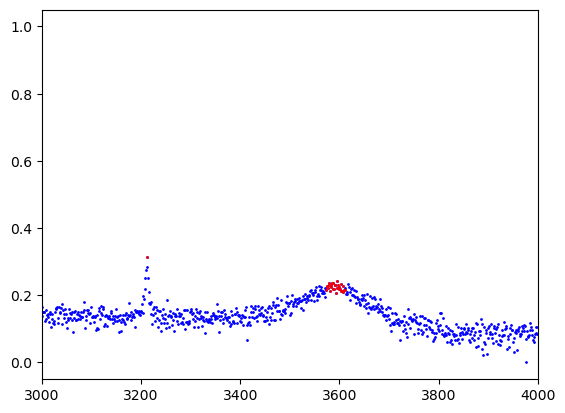

In [56]:
# Plot a sample
i = 1
spectrum = X_train[i]
f = rfftfreq(32768, 1/44100)[0:8192]

labels = y_train[i, :, :]
spread_peak_labels = labels[:, 0]
indices = np.where(spread_peak_labels == 1)[0]
# isolated_peaks = isolated_peaks_train[i]
# indices = np.where(isolated_peaks == 1)[0]
plt.scatter(f, spectrum, color='blue', s=1)
plt.scatter(f[indices], spectrum[indices], color='red', s=1)
plt.xlim(3000, 4000)
plt.show()

In [ ]:
# Verify peak_counting_error
isolated_peaks_val=np.array(
    [[0, 1, 0, 0, 1], 
     [1, 0, 1, 0, 0]]
    )
val_predictions=np.array(
    [[0.81, 0.91, 0.71, 0.31, 0.91],
     [0.81, 0.21, 0.91, 0.96, 0.91]]
    )

peak_counting_error(isolated_peaks_val, val_predictions)

In [ ]:
# Figure out how many bins our peaks are
f = rfftfreq(32768, 1/44100)
# HWFM (in bins) of a peak with a HWHM of 100Hz
bin_width = f[1] - f[0]
print(f"HWFM (in bins) of a peak with a HWHM of 100Hz: {200 / bin_width}")
print(f"HWFM (in bins) of a peak with a HWHM of 10Hz: {20 / bin_width}")
print(f"HWFM (in bins) of a peak with a HWHM of 3Hz: {6 / bin_width}")